In [1]:
import pandas as pd

# do a preliminary read of the csv and attempt to parse column types
dev_2017_pre = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'])

print(dev_2017_pre)

# since the quantity column is parsed generically as object, 
# it likely includes some anomalous (e.g. missing) values 
print(dev_2017_pre.dtypes)

                timestamp      quantity
0     2017-01-01 00:00:00       -44,875
1     2017-01-01 00:30:00       -18,125
2     2017-01-01 01:00:00       -10,375
3     2017-01-01 01:30:00         7,125
4     2017-01-01 02:00:00       -43,375
...                   ...           ...
17535 2017-12-31 22:45:00  -21,48982889
17536 2017-12-31 23:00:00  -7,807809406
17537 2017-12-31 23:15:00  -56,69726053
17538 2017-12-31 23:30:00   21,83256871
17539 2017-12-31 23:45:00   4,452218702

[17540 rows x 2 columns]
timestamp    datetime64[ns]
quantity             object
dtype: object


In [2]:
# rows indices 13594, 13595, 13596 are missing values for deviation
print(dev_2017_pre[dev_2017_pre['quantity']=='na'])


                timestamp quantity
13594 2017-11-10 16:00:00       na
13595 2017-11-10 16:30:00       na
13596 2017-11-10 17:00:00       na


In [3]:
# since only few rows contain missing quantity values, 
# we just load the csv again skipping them
# use 
dev_2017 = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'], skiprows=range(13595,13598))

# check that rows with missing quantity values have been removed
# print(dev_2017[dev_2017['quantity']=='na'])

# another ignored option: filter the loaded dataframe directly.
# however, here we would need to replace commas
# by periods as decimal separators in order to be
# able to parse them as floats

# dev_2017 = dev_2017_pre.loc[dev_2017_pre['quantity']!='na']

In [4]:
# the column types are now correctly parsed
dev_2017.dtypes

timestamp    datetime64[ns]
quantity            float64
dtype: object

In [6]:
# there seem to be some extreme outliers
dev_2017.describe()

,quantity
count,1.753700e+04
mean,-7.852510e+03
std,7.435333e+05
min,-7.898546e+07
25%,-3.087500e+01
50%,2.875000e+00
75%,3.875000e+01
max,5.651250e+02


In [7]:
# look for the timestamps corresponding to these extremes
dev_2017.set_index('timestamp', inplace=True, drop=True)
dev_2017.loc[dev_2017.idxmin()]

,quantity
timestamp,
2017-11-05 04:30:00,-78985465.0


In [8]:
# the maximum value is not as absurd as the minimum, so no
# need to drop it

dev_2017.loc[dev_2017.idxmax()]

,quantity
timestamp,
2017-07-12 04:30:00,565.125


In [9]:
# the entry corresponding to the minimum value is suspicious
# as there don't exist news of massive energy consumption 
# in france on that date. let's drop it from the dataframe
dev_2017.drop(dev_2017.idxmin(), inplace=True)


In [10]:
# the new minimum is also suspicious, let's drop it as well
dev_2017.loc[dev_2017.idxmin()]

,quantity
timestamp,
2017-11-05 04:00:00,-58796353.0


In [11]:
dev_2017.drop(dev_2017.idxmin(), inplace=True)

In [12]:
# the resulting minimum seems more realistic, so we'll keep it

dev_2017.loc[dev_2017.idxmin()]

,quantity
timestamp,
2017-01-25 13:00:00,-340.75


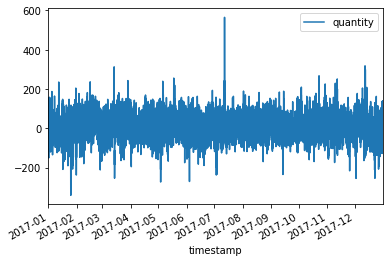

In [17]:
# now let's have a look at the time series. it would be
# unintelligible if we hadn't removed the outliers
dev_2017.plot()

In [18]:
# since we are interested in the relation between daily average 
# consumption and daily average temperature, aggregate the 
# consumption data on a daily basis
dev_2017_daily = dev_2017.resample('D').mean()
dev_2017_daily.head(10)

,quantity
timestamp,
2017-01-01,-25.520833
2017-01-02,98.132812
2017-01-03,-36.273438
2017-01-04,34.421875
2017-01-05,25.817708
2017-01-06,-10.911458
2017-01-07,33.330729
2017-01-08,-27.494792
2017-01-09,26.557292


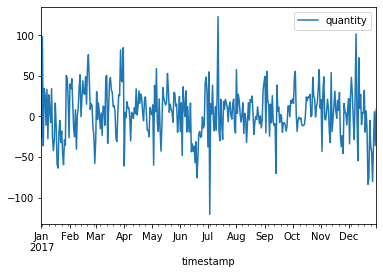

In [19]:
dev_2017_daily.plot()

In [ ]:
# i will choose a weather station close to paris